In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import pickle
import random
random.seed(42)
np.random.seed(42)

In [2]:
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,OrdinalEncoder
from sklearn.preprocessing import StandardScaler,MinMaxScaler 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.feature_selection import f_regression, mutual_info_regression

In [3]:
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.externals import joblib


# 1. Feature Preprocessing

In [4]:
file= 'insurance_data.csv'
df=pd.read_csv(file, sep=',',header='infer')
ft0 = ['ft1','ft2','ft3','ft4', 'ft5', 'ft6']
categorical_columns = ['ft4','ft5','ft6']
#### using pandas only for visulization one-hot encoding
# in the training, using 'make_column_transformer' from sklearn
df_encode = pd.get_dummies(data = df, prefix = None, prefix_sep='_',\
                           columns = categorical_columns, drop_first=False)
print(df_encode.head())

   ft1     ft2  ft3      charges  ft4_female  ft4_male  ft5_no  ft5_yes  \
0   19  27.900    0  16884.92400           1         0       0        1   
1   18  33.770    1   1725.55230           0         1       1        0   
2   28  33.000    3   4449.46200           0         1       1        0   
3   33  22.705    0  21984.47061           0         1       1        0   
4   32  28.880    0   3866.85520           0         1       1        0   

   ft6_northeast  ft6_northwest  ft6_southeast  ft6_southwest  
0              0              0              0              1  
1              0              0              1              0  
2              0              0              1              0  
3              0              1              0              0  
4              0              1              0              0  


In [5]:
# one-hot encoding
preprocess1 = make_column_transformer(
    (OneHotEncoder(sparse=False), ['ft4','ft5','ft6']),
    remainder='passthrough' 
)
# standardization and one-hot encoding
preprocess2 = make_column_transformer(
    (OneHotEncoder(sparse=False), ['ft4','ft5','ft6']),
    (StandardScaler(),['ft1','ft2','ft3']),
    remainder='passthrough'
)
# partial standardization and one-hot encoding
preprocess3 = make_column_transformer(
    (OneHotEncoder(sparse=False), ['ft4','ft5','ft6']),
    (StandardScaler(),['ft2','ft3']),
    remainder='passthrough'
)
# scalar encoding
preprocess4 = make_column_transformer(
    (OrdinalEncoder(), ['ft4','ft5','ft6']),
    remainder='passthrough'
)
def cv_test(model, X, y, k=10, plot=True):
    # cross validation
    kf = KFold(n_splits=k)
    RMSE_train=[]
    RMSE_test=[]
    for train_index, test_index in kf.split(X):
        X_train= X[train_index,:]
        y_train= y[train_index]
        X_test= X[test_index,:]
        y_test= y[test_index]
        reg = model.fit(X_train, y_train)
        pred_train = reg.predict(X_train)
        pred_test = reg.predict(X_test)
        RMSE_train.append(np.sqrt(mean_squared_error(y_train, pred_train)))
        RMSE_test.append(np.sqrt(mean_squared_error(y_test, pred_test)))
    [rmse_train_ave, rmse_test_ave] = [np.mean(RMSE_train), np.mean(RMSE_test)]
    print('RMSE for train data=',rmse_train_ave)
    print('RMSE for test data=',rmse_test_ave)
    
    # test
    reg = model.fit(X, y)
    pred= reg.predict(X)
    if plot:
        plt.figure()
        plt.scatter(y, pred, marker='.')
        plt.plot(y,y,color='black')
        plt.xlabel('true values')
        plt.ylabel('fitted valuse')
        plt.title('fitted values versus true values')
        plt.show()

        plt.figure()
        plt.scatter(pred, y-pred, marker='.')
        plt.plot(pred,np.zeros_like(pred),color='black')
        plt.xlabel('fitted valuse')
        plt.ylabel('residuals')
        plt.title('residuals versus fitted values')
        plt.show()
    
    return pred, rmse_train_ave, rmse_test_ave

## (a) Feature Encoding

In [6]:
X1 = preprocess1.fit_transform(df[ft0])
y = df['charges']

RMSE for train data= 6039.342370581926
RMSE for test data= 6063.643882478561


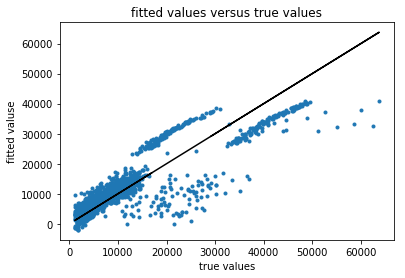

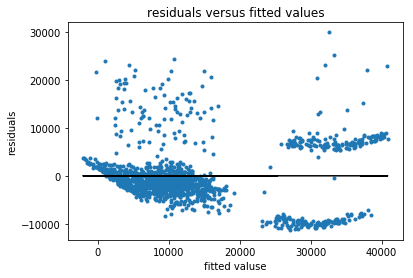

(array([25293.7130284 ,  3448.60283431,  6706.9884907 , ...,
         4149.13248568,  1246.58493898, 37085.62326757]),
 6039.342370581926,
 6063.643882478561)

In [7]:
cv_test(LinearRegression(), X1, y, k=10)

## (b) Standardization

In [8]:
X2 = preprocess2.fit_transform(df[ft0])
y = df['charges']

/home/zeyudesk/anaconda3/envs/219project4/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/zeyudesk/anaconda3/envs/219project4/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


RMSE for train data= 6039.739657933983
RMSE for test data= 6063.717895894306


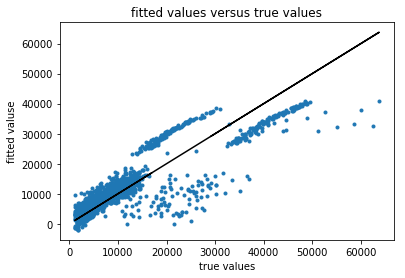

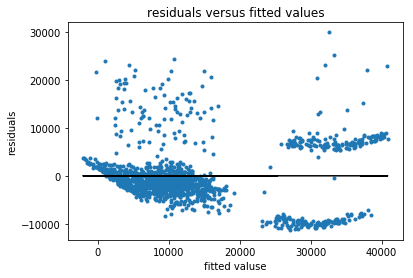

(array([25293.7130284 ,  3448.60283431,  6706.9884907 , ...,
         4149.13248568,  1246.58493898, 37085.62326757]),
 6039.739657933983,
 6063.717895894306)

In [9]:
cv_test(LinearRegression(), X2, y, k=10)

## (c) Divide ft1

In [10]:
import copy
df_div = copy.deepcopy(df)
df_div['ft1'] = [1 if x < 30 else (3 if x > 50 else 2) for x in df['ft1']]
df_div.head()

,ft1,ft2,ft3,ft4,ft5,ft6,charges
0,1,27.900,0,female,yes,southwest,16884.92400
1,1,33.770,1,male,no,southeast,1725.55230
2,1,33.000,3,male,no,southeast,4449.46200
3,2,22.705,0,male,no,northwest,21984.47061
4,2,28.880,0,male,no,northwest,3866.85520


In [11]:
X3 = preprocess3.fit_transform(df_div[ft0])
y = df_div['charges']

/home/zeyudesk/anaconda3/envs/219project4/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/zeyudesk/anaconda3/envs/219project4/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


RMSE for train data= 6199.2545470565965
RMSE for test data= 6220.990196217921


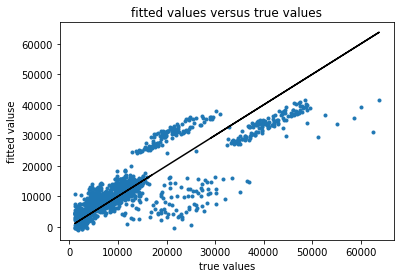

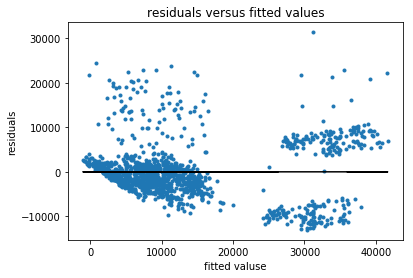

(array([26277.51137211,  4697.72093282,  5410.35133017, ...,
         5410.86251845,  1740.36747767, 36039.16004406]),
 6199.2545470565965,
 6220.990196217921)

In [12]:
cv_test(LinearRegression(), X3, y, k=10)

# 2. Correlation exploration

## (a)

In [13]:
X = preprocess4.fit_transform(df[ft0])
print(preprocess4.transformers_[0][1].categories_)
y = df['charges']

[array(['female', 'male'], dtype=object), array(['no', 'yes'], dtype=object), array(['northeast', 'northwest', 'southeast', 'southwest'], dtype=object)]


In [14]:
print(X[:5,:])

[[ 0.     1.     3.    19.    27.9    0.   ]
 [ 1.     0.     2.    18.    33.77   1.   ]
 [ 1.     0.     2.    28.    33.     3.   ]
 [ 1.     0.     1.    33.    22.705  0.   ]
 [ 1.     0.     1.    32.    28.88   0.   ]]


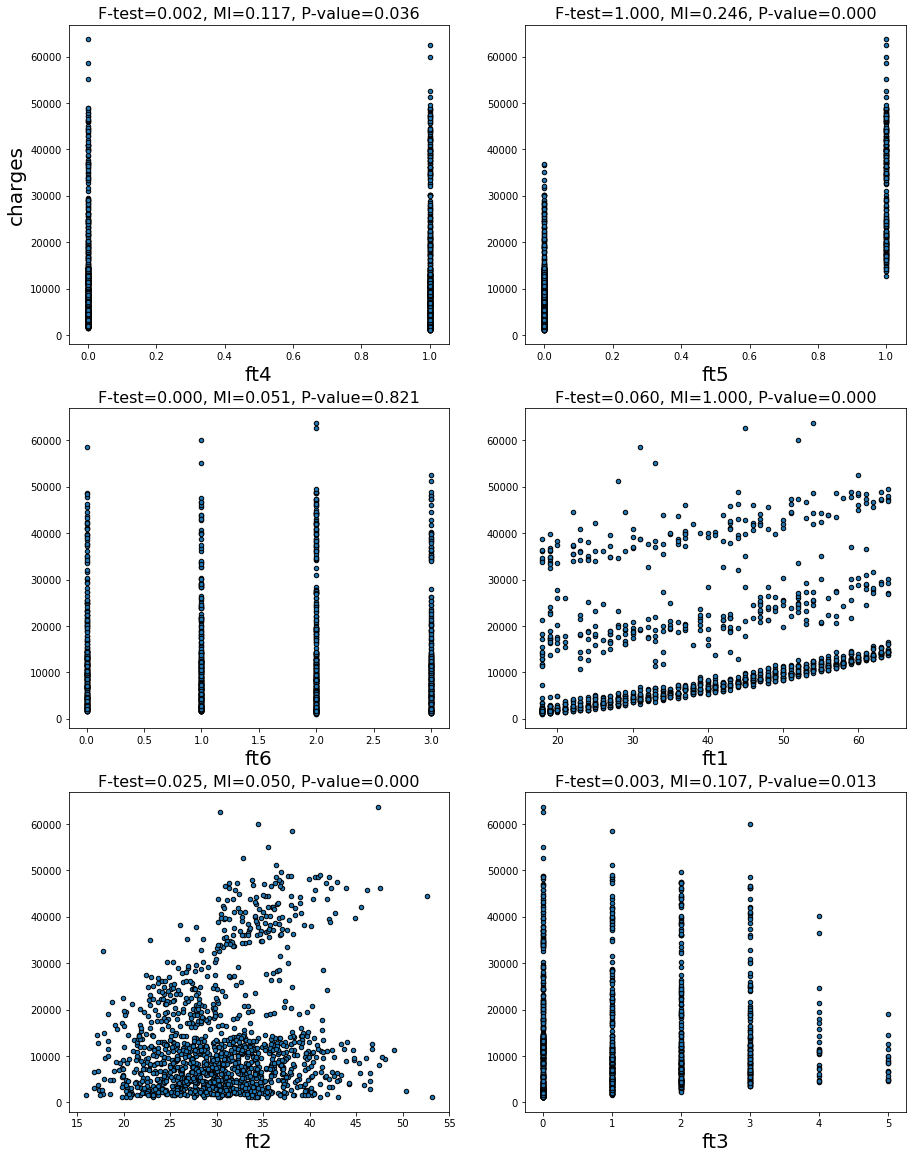

In [15]:
fts = ['ft4','ft5','ft6', 'ft1','ft2','ft3']
f_test, P_val = f_regression(X, y)
f_test /= np.max(f_test)

mi = mutual_info_regression(X, y)
mi /= np.max(mi)

plt.figure(figsize=(15, 20))
for i in range(6):
    plt.subplot(3, 2, i + 1)
    plt.scatter(X[:, i], y, edgecolor='black', s=20)
    plt.xlabel("{:s}".format(fts[i]), fontsize=20)
    if i == 0:
        plt.ylabel("charges", fontsize=20)
    plt.title("F-test={:.3f}, MI={:.3f}, P-value={:.3f}".format(f_test[i], mi[i], P_val[i]),
              fontsize=16)
plt.show()

## (b) (c)

Text(0, 0.5, 'charges')

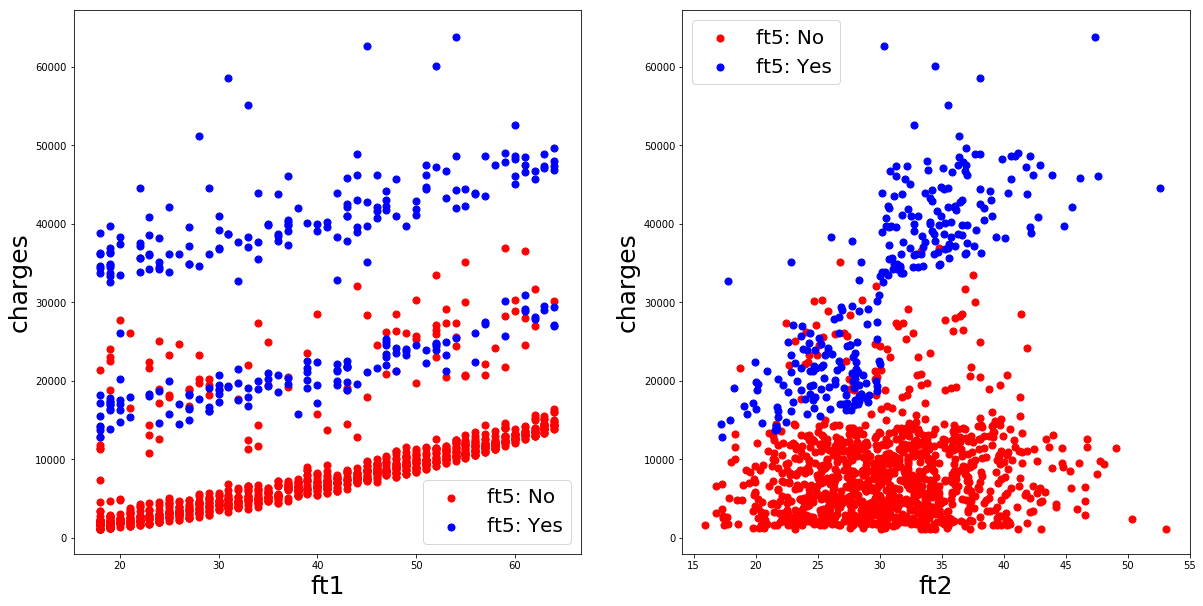

In [16]:
mask1 = X[:,1]==0
mask2 = X[:,1]==1
plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.scatter(X[mask1,3], y[mask1], s=50, c='red', label='ft5: No')
plt.scatter(X[mask2,3], y[mask2], s=50, c='blue', label='ft5: Yes')
plt.legend(fontsize=20)
plt.xlabel("{:s}".format(fts[3]), fontsize=25)
plt.ylabel("charges", fontsize=25)

plt.subplot(122)
plt.scatter(X[mask1,4], y[mask1], s=50, c='red', label='ft5: No')
plt.scatter(X[mask2,4], y[mask2], s=50, c='blue', label='ft5: Yes')
plt.legend(fontsize=20)
plt.xlabel("{:s}".format(fts[4]), fontsize=25)
plt.ylabel("charges", fontsize=25)

# 3. Modify the target variable

## (a) Linear regression

In [17]:
# choose preprocessing in 1(b)
X = preprocess2.fit_transform(df[ft0])
y = df['charges']
y_log = np.log(y)

/home/zeyudesk/anaconda3/envs/219project4/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/zeyudesk/anaconda3/envs/219project4/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


RMSE for train data= 8355.004524267348
RMSE for test data= 8368.933948012018


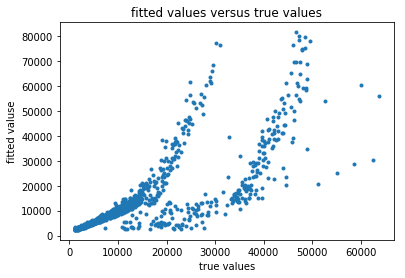

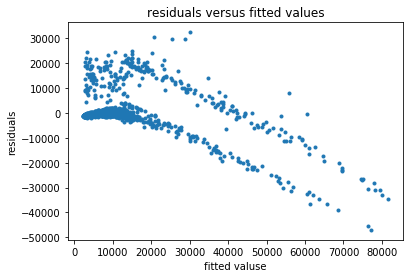

In [18]:
kf = KFold(n_splits=10)
RMSE_train=[]
RMSE_test=[]
for train_index, test_index in kf.split(X):
    X_train= X[train_index]
    y_train= y_log[train_index]
    X_test= X[test_index]
    y_test= y_log[test_index]
    reg = LinearRegression().fit(X_train, y_train)
    pred_train = reg.predict(X_train)
    pred_test = reg.predict(X_test)
    RMSE_train.append(np.sqrt(mean_squared_error(y[train_index], np.exp(pred_train))))
    RMSE_test.append(np.sqrt(mean_squared_error(y[test_index], np.exp(pred_test))))
print('RMSE for train data=',np.mean(RMSE_train))
print('RMSE for test data=',np.mean(RMSE_test))

# test
reg = LinearRegression().fit(X, y_log)
pred= np.exp(reg.predict(X))
plt.figure()
plt.scatter(y, pred, marker='.')
plt.xlabel('true values')
plt.ylabel('fitted valuse')
plt.title('fitted values versus true values')
plt.show()

plt.figure()
plt.scatter(pred, y-pred, marker='.')
plt.xlabel('fitted valuse')
plt.ylabel('residuals')
plt.title('residuals versus fitted values')
plt.show()

## (b) Correlation

In [19]:
X = preprocess4.fit_transform(df[ft0])
print(preprocess4.transformers_[0][1].categories_)
y = df['charges']
y_log = np.log(y)

[array(['female', 'male'], dtype=object), array(['no', 'yes'], dtype=object), array(['northeast', 'northwest', 'southeast', 'southwest'], dtype=object)]


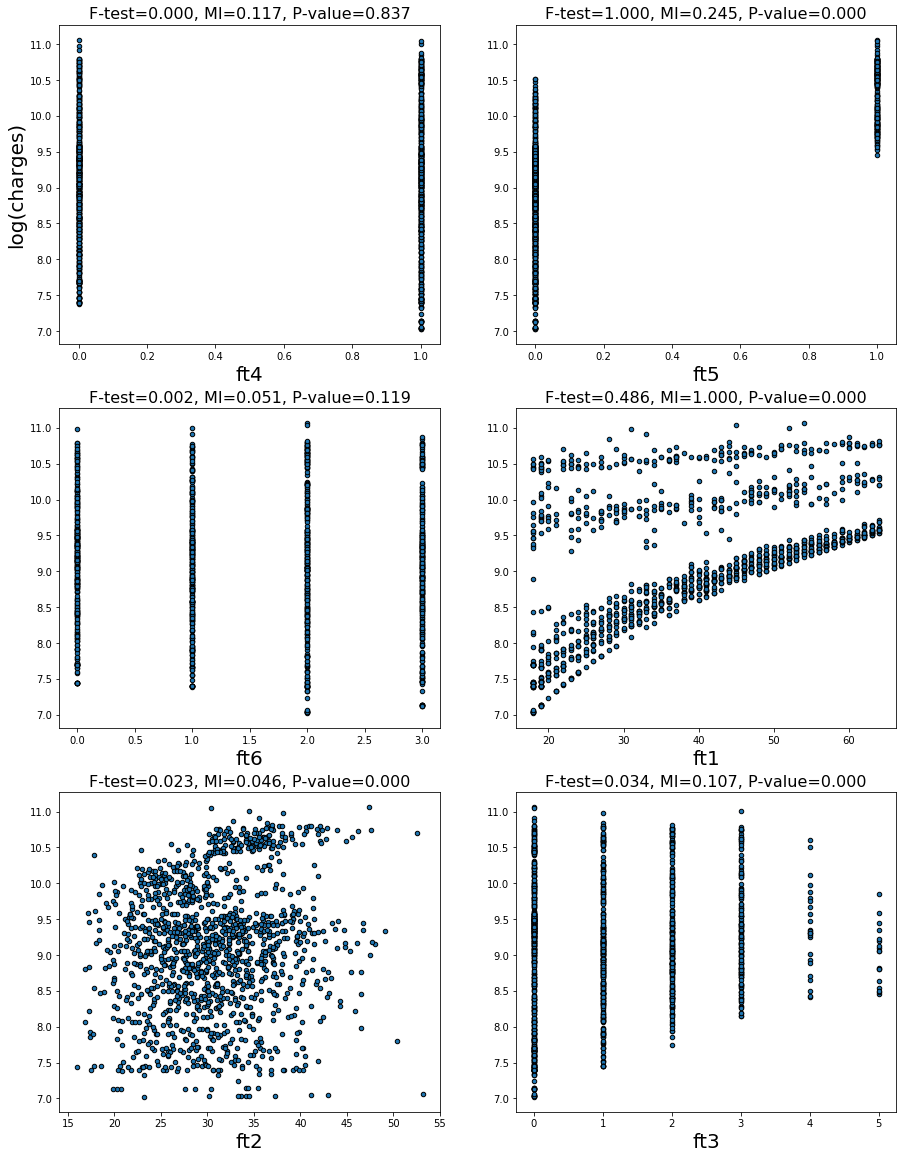

In [20]:
fts = ['ft4','ft5','ft6', 'ft1','ft2','ft3']
f_test, P_val = f_regression(X, y_log)
f_test /= np.max(f_test)

mi = mutual_info_regression(X, y_log)
mi /= np.max(mi)

plt.figure(figsize=(15, 20))
for i in range(6):
    plt.subplot(3, 2, i + 1)
    plt.scatter(X[:, i], y_log, edgecolor='black', s=20)
    plt.xlabel("{:s}".format(fts[i]), fontsize=20)
    if i == 0:
        plt.ylabel("log(charges)", fontsize=20)
    plt.title("F-test={:.3f}, MI={:.3f}, P-value={:.3f}".format(f_test[i], mi[i], P_val[i]),
              fontsize=16)
plt.show()

Text(0, 0.5, 'charges')

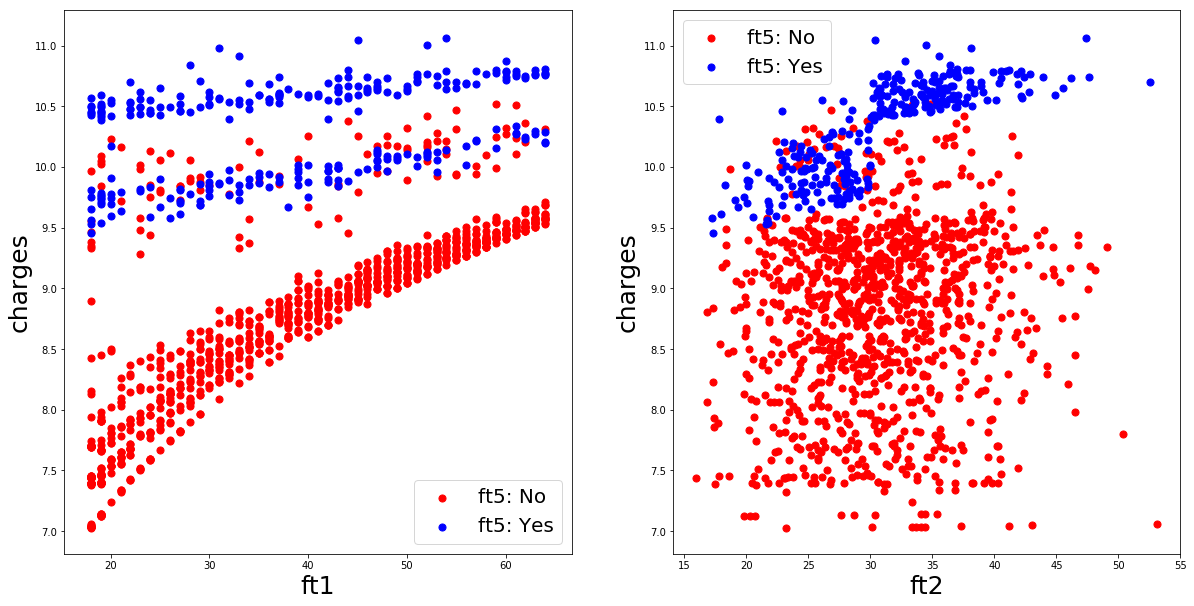

In [21]:
mask1 = X[:,1]==0
mask2 = X[:,1]==1
plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.scatter(X[mask1,3], y_log[mask1], s=50, c='red', label='ft5: No')
plt.scatter(X[mask2,3], y_log[mask2], s=50, c='blue', label='ft5: Yes')
plt.legend(fontsize=20)
plt.xlabel("{:s}".format(fts[3]), fontsize=25)
plt.ylabel("charges", fontsize=25)

plt.subplot(122)
plt.scatter(X[mask1,4], y_log[mask1], s=50, c='red', label='ft5: No')
plt.scatter(X[mask2,4], y_log[mask2], s=50, c='blue', label='ft5: Yes')
plt.legend(fontsize=20)
plt.xlabel("{:s}".format(fts[4]), fontsize=25)
plt.ylabel("charges", fontsize=25)

# 4 Bonus questions:

## (a) Polymonial features

degree =  1
Results without standardization
RMSE for train data= 6039.342370581925
RMSE for test data= 6063.643882478562


/home/zeyudesk/anaconda3/envs/219project4/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/zeyudesk/anaconda3/envs/219project4/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


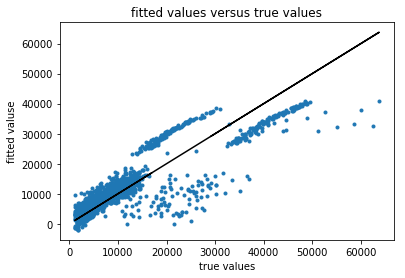

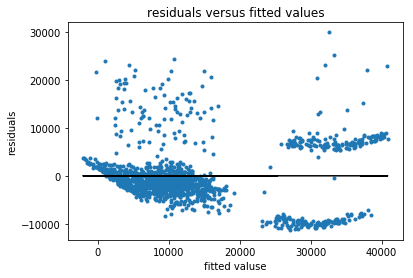

Results with standardization
RMSE for train data= 6039.342370581926
RMSE for test data= 6063.643882478562


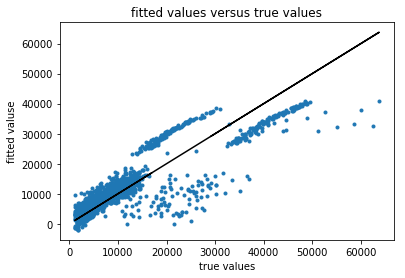

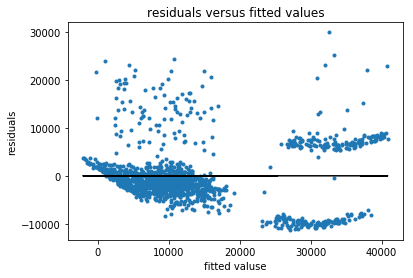

degree =  2
Results without standardization
RMSE for train data= 5470.137427767257
RMSE for test data= 5336.965136700071


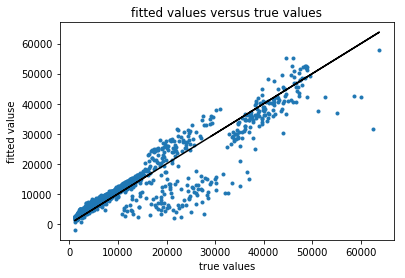

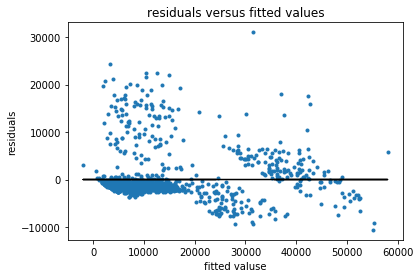

Results with standardization
RMSE for train data= 4736.316769060873
RMSE for test data= 4832.399680523234


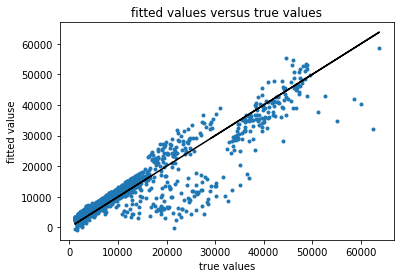

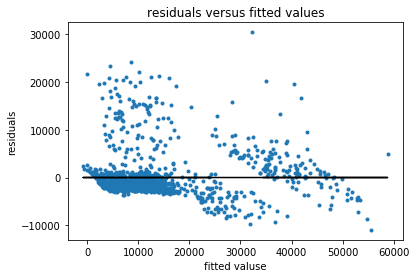

degree =  3
Results without standardization
RMSE for train data= 6052.891551144257
RMSE for test data= 6541.376995750353


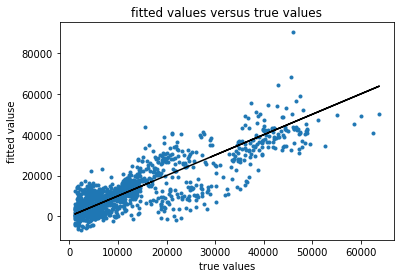

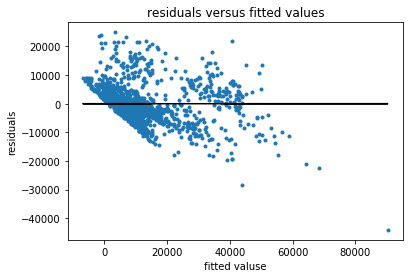

Results with standardization
RMSE for train data= 4601.065013720535
RMSE for test data= 4890.519041432834


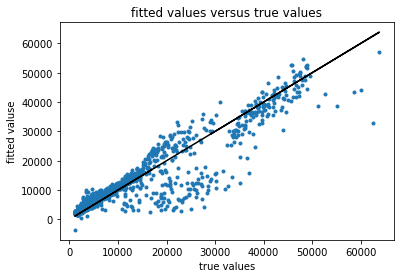

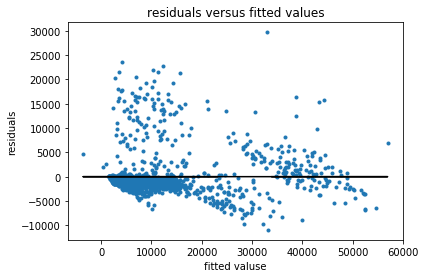

degree =  4
Results without standardization
RMSE for train data= 4751.82434513976
RMSE for test data= 5650.221199020948


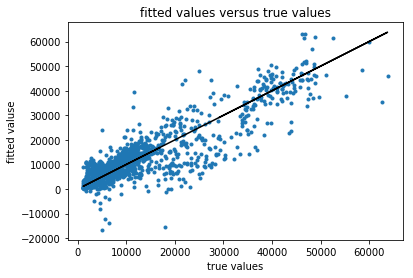

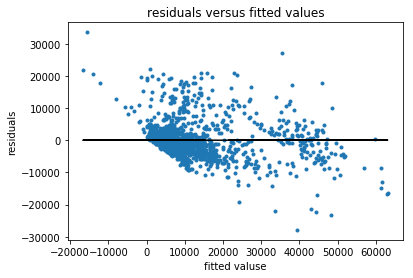

Results with standardization
RMSE for train data= 4413.803469870466
RMSE for test data= 5171.9194567015775


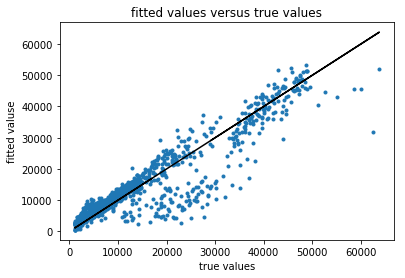

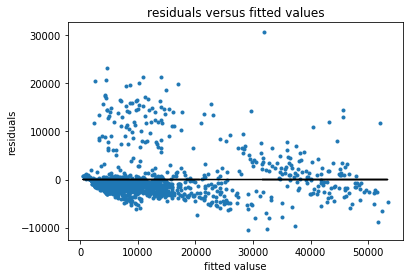

degree =  5
Results without standardization
RMSE for train data= 4076.937281392591
RMSE for test data= 6782.190794836848


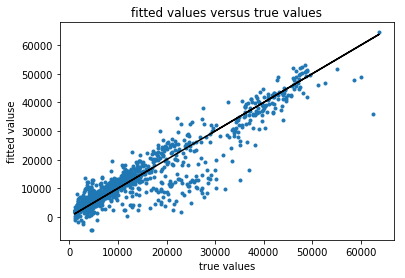

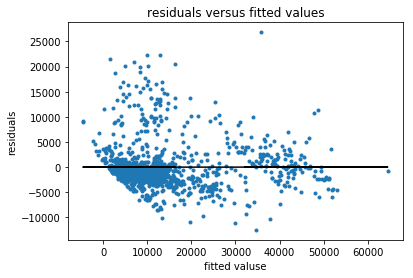

Results with standardization
RMSE for train data= 4067.057064048598
RMSE for test data= 6744.182908880796


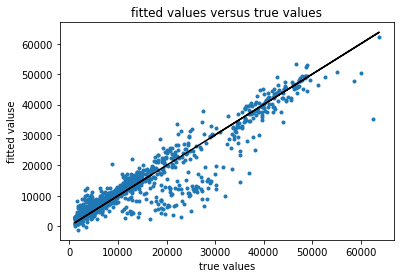

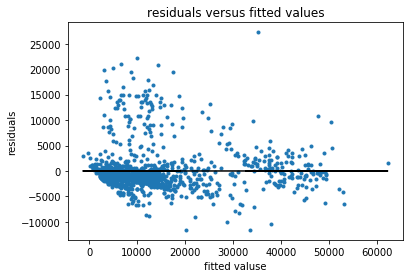

degree =  6
Results without standardization
RMSE for train data= 3681.4505889098646
RMSE for test data= 101559.89913090537


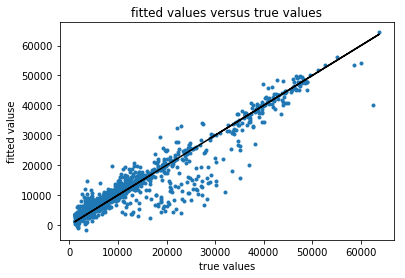

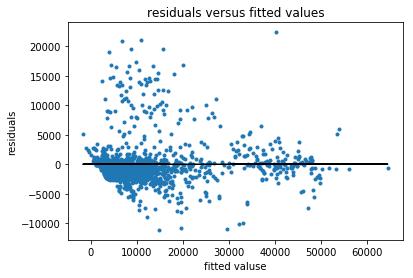

Results with standardization
RMSE for train data= 3673.4177465156763
RMSE for test data= 22666.635939020554


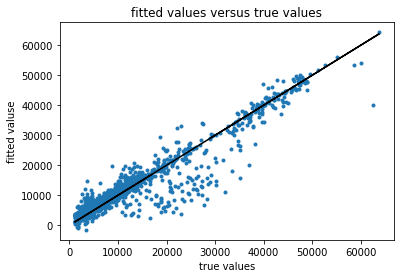

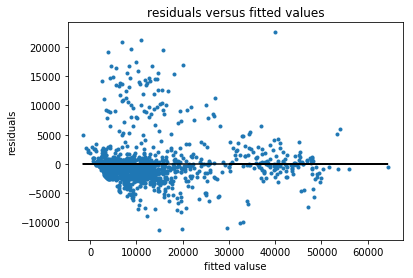

In [22]:
degrees = [1, 2, 3, 4, 5, 6]
X1 = preprocess1.fit_transform(df[ft0])
X2 = preprocess2.fit_transform(df[ft0])
y = df['charges']
RMSE_train1 = []
RMSE_test1 = []
RMSE_train2 = []
RMSE_test2 = []
for degree in degrees:
    print('degree = ', degree)
    poly = PolynomialFeatures(degree)
    X1_poly = np.concatenate((poly.fit_transform(X1[:,3:]), X1[:,:3]), axis=1)
    X2_poly = np.concatenate((poly.fit_transform(X2[:,3:]), X2[:,:3]), axis=1)
    
    print('Results without standardization')
    _, rmse_train1, rmse_test1 = cv_test(LinearRegression(), X1_poly, y, k=10)
    RMSE_train1.append(rmse_train1)
    RMSE_test1.append(rmse_test1)
    
    print('Results with standardization')
    _, rmse_train2, rmse_test2 = cv_test(LinearRegression(), X2_poly, y, k=10)
    RMSE_train2.append(rmse_train2)
    RMSE_test2.append(rmse_test2)
    


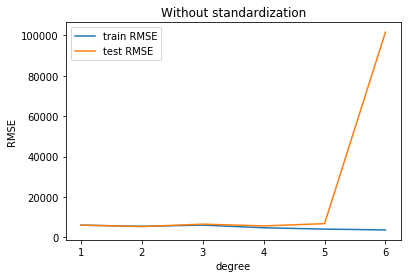

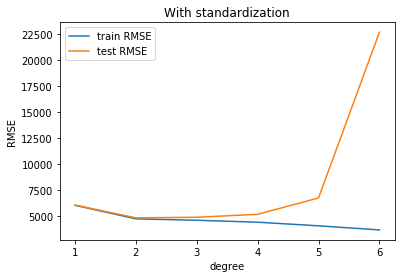

Without standadization:
train RMSE: [6039.342370581925, 5470.137427767257, 6052.891551144257, 4751.82434513976, 4076.937281392591, 3681.4505889098646]
test RMSE: [6063.643882478562, 5336.965136700071, 6541.376995750353, 5650.221199020948, 6782.190794836848, 101559.89913090537]


With standadization:
train RMSE: [6039.342370581926, 4736.316769060873, 4601.065013720535, 4413.803469870466, 4067.057064048598, 3673.4177465156763]
test RMSE: [6063.643882478562, 4832.399680523234, 4890.519041432834, 5171.9194567015775, 6744.182908880796, 22666.635939020554]


In [23]:
plt.plot(degrees, RMSE_train1, degrees, RMSE_test1)
plt.title('Without standardization')
plt.xlabel('degree')
plt.ylabel('RMSE')
plt.legend(['train RMSE','test RMSE'])
plt.show()

plt.plot(degrees, RMSE_train2, degrees, RMSE_test2)
plt.title('With standardization')
plt.xlabel('degree')
plt.ylabel('RMSE')
plt.legend(['train RMSE','test RMSE'])
plt.show()

print('Without standadization:')
print('train RMSE:', RMSE_train1)
print('test RMSE:', RMSE_test1)
print('\n')
print('With standadization:')
print('train RMSE:', RMSE_train2)
print('test RMSE:', RMSE_test2)

In [24]:
print('Polynomial transformation with degree 2 after standadization has lowest test RMSE')
d_best = 2

Polynomial transformation with degree 2 after standadization has lowest test RMSE


## (b)

### Random forest

In [25]:
# scalar encoding on categorical features
X = preprocess4.fit_transform(df[ft0])
print(preprocess4.transformers_[0][1].categories_)
y = df['charges']

[array(['female', 'male'], dtype=object), array(['no', 'yes'], dtype=object), array(['northeast', 'northwest', 'southeast', 'southwest'], dtype=object)]


RMSE for train data= 4285.114243887098
RMSE for test data= 4499.004658387674


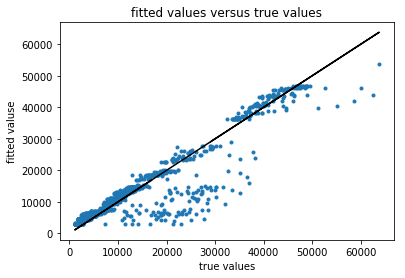

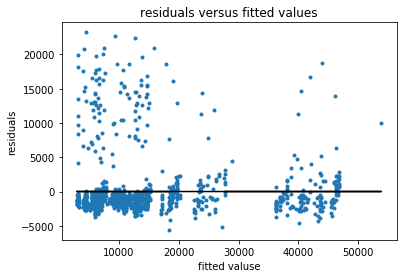

(array([18478.09985053,  4483.45765512,  6579.86097004, ...,
         3149.18967596,  3149.18967596, 27818.14062133]),
 4285.114243887098,
 4499.004658387674)

In [26]:
model = RandomForestRegressor(n_estimators=20,
                              max_depth=4, 
                              bootstrap=True,
                              max_features=5,
                              random_state=42)
cv_test(model, X, y, k=10)

#### hyper-parameters search of random forest

In [27]:
# parameters = {'n_estimators': [10, 20, 50, 100, 150, 200], 
#               'max_depth': [2, 3, 4, 5, 6],
#               'max_features': [2, 3, 4, 5, 6]}
# clf1 = GridSearchCV(RandomForestRegressor(bootstrap=True,random_state=42), 
#                    parameters, cv=10, scoring='neg_mean_squared_error',
#                    iid=True,return_train_score=True)
# clf1.fit(X, y)

In [28]:
### load the model and show results
# clf1 = pickle.load(open('clf_rf.sav', 'rb'))
# pd.DataFrame(clf1.cv_results_)
clf1 = joblib.load('clf_rf_skl.sav')
pd.DataFrame(clf1.cv_results_)

CVres = pd.DataFrame(clf1.cv_results_)
CVres[['rank_test_score',
       'mean_test_score',
       'mean_train_score',
       'param_max_depth',
       'param_max_features',
       'param_n_estimators']][CVres['rank_test_score']<=10]

,rank_test_score,mean_test_score,mean_train_score,param_max_depth,param_max_features,param_n_estimators
83,8,-2.041886e+07,-1.818180e+07,4,5,200
104,7,-2.040034e+07,-1.670960e+07,5,4,50
105,3,-2.027085e+07,-1.663150e+07,5,4,100
106,1,-2.019962e+07,-1.661171e+07,5,4,150
107,2,-2.021135e+07,-1.660430e+07,5,4,200
109,9,-2.042859e+07,-1.642696e+07,5,5,20
111,6,-2.037859e+07,-1.631445e+07,5,5,100
112,4,-2.034082e+07,-1.631310e+07,5,5,150
113,5,-2.037533e+07,-1.629314e+07,5,5,200
137,10,-2.043670e+07,-1.427688e+07,6,4,200


### Neural network

In [29]:
# One-hot encoding on categorical features
X = preprocess1.fit_transform(df[ft0])
y = df['charges']

/home/zeyudesk/anaconda3/envs/219project4/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/zeyudesk/anaconda3/envs/219project4/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/zeyudesk/anaconda3/envs/219project4/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/zeyudesk/anaconda3/envs/219project4/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimi

RMSE for train data= 11853.450692300019
RMSE for test data= 11827.213882548645


/home/zeyudesk/anaconda3/envs/219project4/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


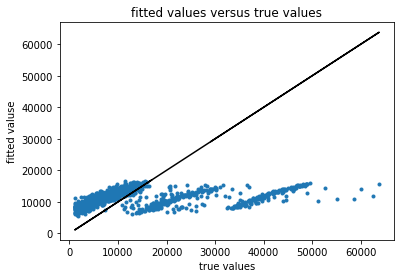

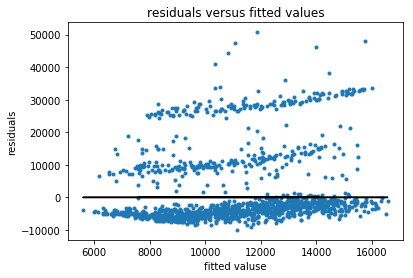

(array([ 7600.58192097,  8409.58679928, 10089.57054991, ...,
         8714.29667915,  7509.90656195, 14068.98653769]),
 11853.450692300019,
 11827.213882548645)

In [30]:
model = MLPRegressor(hidden_layer_sizes=(100,),
                     activation='relu', solver='adam', max_iter=200, 
                     alpha=1e-4, random_state=42,verbose=False)
cv_test(model, X, y, k=10)

#### hyper-parameters search of Neural network

In [31]:
# parameters = {'hidden_layer_sizes': [10, 50, 100, 150, 200], 
#               'activation': ['logistic', 'tanh', 'relu'],
#               'alpha': [1e-5,3e-5,1e-4,3e-4,1e-3]}
# clf2 = GridSearchCV(MLPRegressor(solver='adam',max_iter=200,random_state=42,verbose=False), 
#                    parameters, cv=10, scoring='neg_mean_squared_error',
#                    iid=True,return_train_score=True)
# clf2.fit(X, y)

In [32]:
### load the model and show results
# clf2 = pickle.load(open('clf_nn.sav', 'rb'))
# pd.DataFrame(clf2.cv_results_)
clf2 = joblib.load('clf_nn_skl.sav')
pd.DataFrame(clf2.cv_results_)

CVres = pd.DataFrame(clf2.cv_results_)
CVres[['rank_test_score',
       'mean_test_score',
       'mean_train_score',
       'param_hidden_layer_sizes',
       'param_activation',
       'param_alpha']][CVres['rank_test_score']<=10]

,rank_test_score,mean_test_score,mean_train_score,param_hidden_layer_sizes,param_activation,param_alpha
53,10,-1.304418e+08,-1.303371e+08,150,relu,1e-05
54,5,-1.292287e+08,-1.290147e+08,200,relu,1e-05
58,9,-1.303852e+08,-1.302863e+08,150,relu,3e-05
59,4,-1.291343e+08,-1.289035e+08,200,relu,3e-05
63,6,-1.302948e+08,-1.301839e+08,150,relu,0.0001
64,1,-1.290666e+08,-1.288454e+08,200,relu,0.0001
68,7,-1.303243e+08,-1.302249e+08,150,relu,0.0003
69,2,-1.290956e+08,-1.288678e+08,200,relu,0.0003
73,8,-1.303522e+08,-1.302328e+08,150,relu,0.001
74,3,-1.290995e+08,-1.288636e+08,200,relu,0.001


### Gradient boosting tree

In [33]:
# scalar encoding on categorical features
X = preprocess4.fit_transform(df[ft0])
print(preprocess4.transformers_[0][1].categories_)
y = df['charges']

[array(['female', 'male'], dtype=object), array(['no', 'yes'], dtype=object), array(['northeast', 'northwest', 'southeast', 'southwest'], dtype=object)]


RMSE for train data= 3785.5640071511166
RMSE for test data= 4510.360014467094


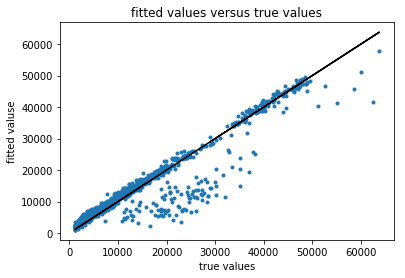

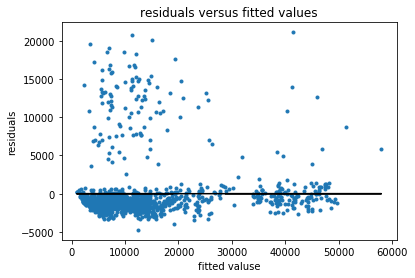

(array([18901.83209496,  3825.97363097,  7069.6082779 , ...,
         2728.80864321,  2284.51713902, 28824.22344789]),
 3785.5640071511166,
 4510.360014467094)

In [34]:
model = GradientBoostingRegressor(learning_rate = 0.1,
                                  n_estimators=100,
                                  max_depth=3, 
                                  random_state=42)
cv_test(model, X, y, k=10)

#### hyper-parameters search of gradient boosting tree

In [35]:
# parameters = {'learning_rate': [1e-2, 3e-2, 1e-1, 3e-1, 1],
#               'n_estimators': [20, 50, 100, 150, 200], 
#               'max_depth': [2, 3, 4, 5, 6],
#               'max_features': [2, 3, 4, 5, 6]}
# clf3 = GridSearchCV(GradientBoostingRegressor(random_state=42), 
#                    parameters, cv=10, scoring='neg_mean_squared_error',
#                    iid=True,return_train_score=True)
# clf3.fit(X, y)

In [36]:
### load the model and show results
# clf3 = pickle.load(open('clf_gb.sav', 'rb'))
# pd.DataFrame(clf3.cv_results_)
clf3 = joblib.load('clf_gb_skl.sav')
pd.DataFrame(clf3.cv_results_)

CVres = pd.DataFrame(clf3.cv_results_)
CVres[['rank_test_score',
       'mean_test_score',
       'mean_train_score',
       'param_learning_rate',
       'param_max_depth',
       'param_max_features',
       'param_n_estimators']][CVres['rank_test_score']<=10]

,rank_test_score,mean_test_score,mean_train_score,param_learning_rate,param_max_depth,param_max_features,param_n_estimators
163,8,-2.020534e+07,-1.728370e+07,0.03,3,4,150
164,9,-2.022392e+07,-1.645882e+07,0.03,3,4,200
168,1,-2.002016e+07,-1.708036e+07,0.03,3,5,150
169,3,-2.009824e+07,-1.623305e+07,0.03,3,5,200
173,6,-2.012757e+07,-1.700611e+07,0.03,3,6,150
174,7,-2.017971e+07,-1.610938e+07,0.03,3,6,200
286,4,-2.010456e+07,-1.685666e+07,0.1,3,4,50
291,2,-2.006813e+07,-1.670344e+07,0.1,3,5,50
296,5,-2.012622e+07,-1.661910e+07,0.1,3,6,50
420,10,-2.030500e+07,-1.595803e+07,0.3,3,6,20


### Save cross-validation results

In [37]:
# save the model to disk using python built-in method
filename1 = 'clf_rf.sav'
pickle.dump(clf1, open(filename1, 'wb'))
filename2 = 'clf_nn.sav'
pickle.dump(clf2, open(filename2, 'wb'))
filename3 = 'clf_gb.sav'
pickle.dump(clf3, open(filename3, 'wb'))

# save the model to disk using scikit-learn package
filename1 = 'clf_rf_skl.sav'
joblib.dump(clf1, filename1)
filename2 = 'clf_nn_skl.sav'
joblib.dump(clf2, filename2)
filename3 = 'clf_gb_skl.sav'
joblib.dump(clf3, filename3)

['clf_gb_skl.sav']

### visualization of the best model for dateset 3

#### random forest

In [38]:
# scalar encoding on categorical features
X = preprocess4.fit_transform(df[ft0])
print(preprocess4.transformers_[0][1].categories_)
y = df['charges']

[array(['female', 'male'], dtype=object), array(['no', 'yes'], dtype=object), array(['northeast', 'northwest', 'southeast', 'southwest'], dtype=object)]


RMSE for train data= 4075.268432930597
RMSE for test data= 4449.8899380268285


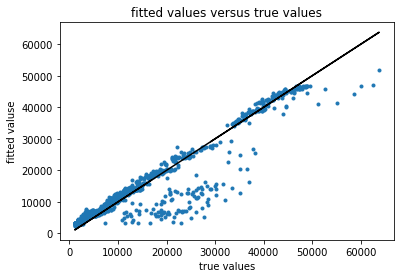

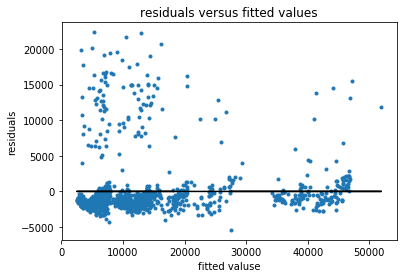

(array([18096.10449037,  4365.41500005,  6044.85495607, ...,
         3322.54665681,  2971.73618601, 27583.58184485]),
 4075.268432930597,
 4449.8899380268285)

In [39]:
model = RandomForestRegressor(n_estimators=150,
                              max_depth=5, 
                              bootstrap=True,
                              max_features=4,
                              random_state=42)
cv_test(model, X, y, k=10)

#### neural network

In [40]:
# One-hot encoding on categorical features
X = preprocess1.fit_transform(df[ft0])
y = df['charges']

/home/zeyudesk/anaconda3/envs/219project4/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/zeyudesk/anaconda3/envs/219project4/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/zeyudesk/anaconda3/envs/219project4/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/zeyudesk/anaconda3/envs/219project4/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimi

RMSE for train data= 11350.78583390454
RMSE for test data= 11341.185232789305


/home/zeyudesk/anaconda3/envs/219project4/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


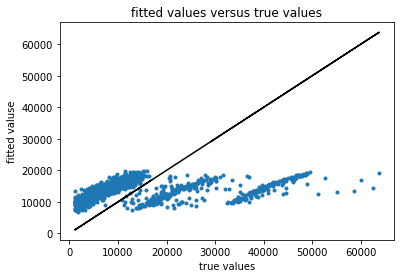

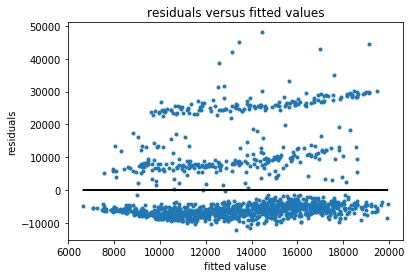

(array([ 9200.629119  , 10041.02104096, 12089.36403347, ...,
        10376.50672659,  8890.61651163, 17087.48099527]),
 11350.78583390454,
 11341.185232789305)

In [41]:
model = MLPRegressor(hidden_layer_sizes=(200,),
                     activation='relu', solver='adam', max_iter=200, 
                     alpha=1e-4, random_state=42,verbose=False)
cv_test(model, X, y, k=10)

#### gradient boosting

In [42]:
# scalar encoding on categorical features
X = preprocess4.fit_transform(df[ft0])
print(preprocess4.transformers_[0][1].categories_)
y = df['charges']

[array(['female', 'male'], dtype=object), array(['no', 'yes'], dtype=object), array(['northeast', 'northwest', 'southeast', 'southwest'], dtype=object)]


RMSE for train data= 4132.36368277382
RMSE for test data= 4429.661429513591


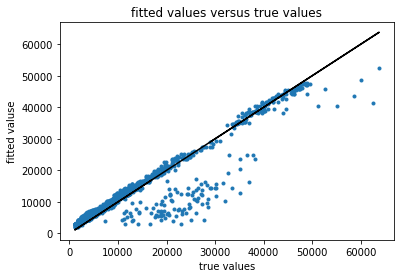

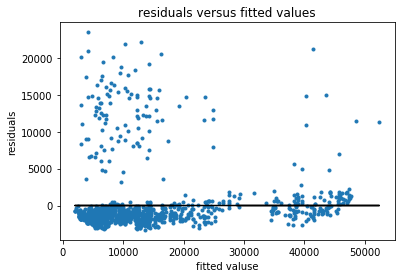

(array([18282.46042946,  4075.49089882,  6356.504883  , ...,
         3123.7162118 ,  2766.41198028, 28902.04899369]),
 4132.36368277382,
 4429.661429513591)

In [43]:
learning_rate = 0.03
max_depth = 3
max_features = 5
n_estimators = 150
model = GradientBoostingRegressor(learning_rate=learning_rate,
                                  n_estimators=n_estimators,
                                  max_features=max_features,
                                  max_depth=max_depth, 
                                  random_state=42)
cv_test(model, X, y, k=10)